- id - 각 여행에 대한 고유 식별자
- vendor_id - 여행 기록과 관련된 공급자를 나타내는 코드
- pickup_datetime - 미터가 사용된 날짜 및 시간
- dropoff_datetime - 측정기가 해제된 날짜 및 시간
- passenger_count - 차량에 탑승한 승객 수(운전자가 입력한 값)
- pickup_longitude - 미터가 연결된 경도
- pickup_latitude - 미터가 사용된 위도
- dropoff_longitude - 미터가 해제된 경도
- dropoff_latitude - 미터가 해제된 위도
- store_and_fwd_flag - 이 플래그는 차량이 서버에 연결되어 있지 않기 때문에 벤더에게 전송하기 전에 이동 기록이 차량 메모리에 보관되었는지 여부를 나타냅니다. - Y=저장 후 전달; N=매장 아님 앞으로 여행
- trip_duration - 여행 기간(초)

- introduction
 - 하루 동안 택시 승차 트래픽은 어떻게 변화할까요?
 - 이 질문에 답하기 위해 K-평균 클러스터링을 사용하여 뉴욕을 위치에 따라 여러 그룹으로 클러스터링하고 각 클러스터로 들어오고 나가는 트래픽을 하루 중 시간에 따른 함수로 분석합니다. 
 - 주거 지역은 저녁에 유입되는 트래픽이 더 많은 반면, 상업 지역은 낮에 주로 사람들이 모이고 밤에 유흥이 풍부한 지역은 밤에 더 많은 트래픽을 보일 것으로 예상할 수 있습니다.

- 이를 통해 하루 중 시간대별로 각 지역의 목적지가 어디인지 파악할 수 있으므로 체류 시간 예측에 유용할 수 있습니다.

In [61]:
import os
import pandas as pd
import numpy as np
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import cm
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from dateutil import parser
import io
import base64
from IPython.display import HTML
from imblearn.under_sampling import RandomUnderSampler
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

ls: ../input: No such file or directory


CalledProcessError: Command '['ls', '../input']' returned non-zero exit status 1.

- Read the data

In [18]:
df = pd.read_csv('train.csv')

In [19]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


- Remove rides to and from far away areas

In [20]:
# 아래의 범위 안에 오는 데이터로 정리
xlim = [-74.03 , -73.77]
ylim = [40.63, 40.85]

df = df[(df.pickup_longitude > xlim[0]) & (df.pickup_longitude < xlim[1])]
df = df[(df.dropoff_longitude > xlim[0]) & (df.dropoff_longitude < xlim[1])]
df = df[(df.pickup_latitude > ylim[0]) & (df.pickup_latitude < ylim[1])]
df = df[(df.dropoff_latitude > ylim[0]) & (df.dropoff_latitude < ylim[1])]


In [24]:
#df 확인해보기
df.shape

(1438626, 11)

- Plot rides

In [26]:
# 픽업할때, 내릴때의 경도 위도를 각각 더해 리스트 형으로 만들기
longitude = list(df.pickup_longitude) + list(df.dropoff_longitude)
latitude = list(df.pickup_latitude) + list(df.dropoff_latitude)

len(longitude)

2877252

<function matplotlib.pyplot.show(close=None, block=None)>

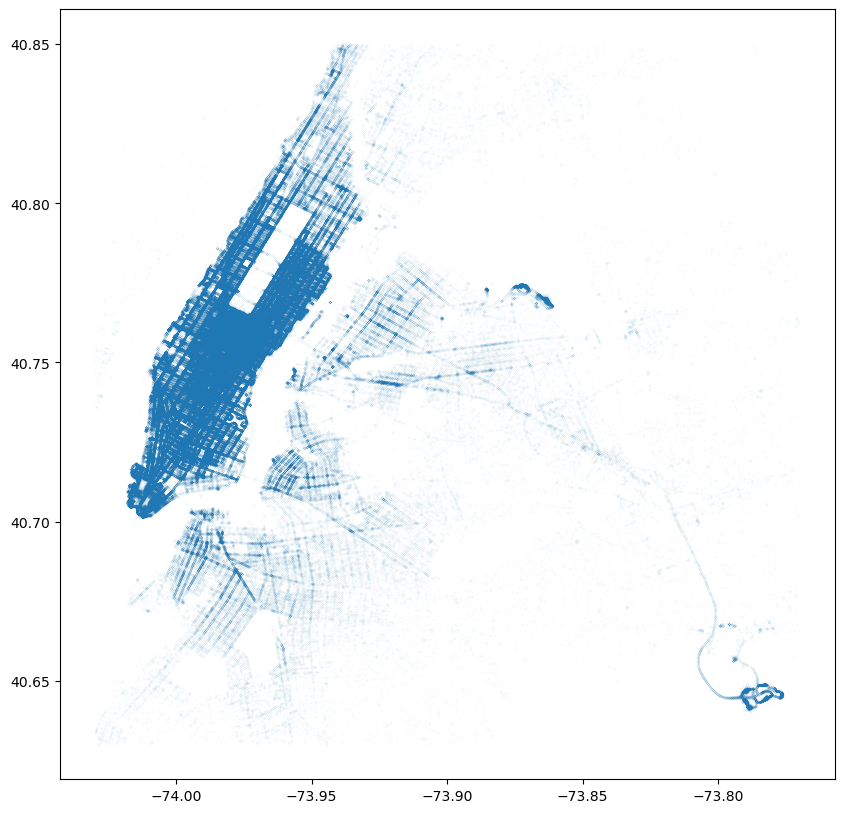

In [23]:
plt.figure(figsize = (10,10))
plt.plot(longitude, latitude, '.', alpha = 0.4, markersize=0.05)
plt.show

In [27]:
#위도와 경도를 담은 데이터 프레임 생성
loc_df = pd.DataFrame()
loc_df['longitude'] = longitude
loc_df['latitude'] = latitude

- Cluster

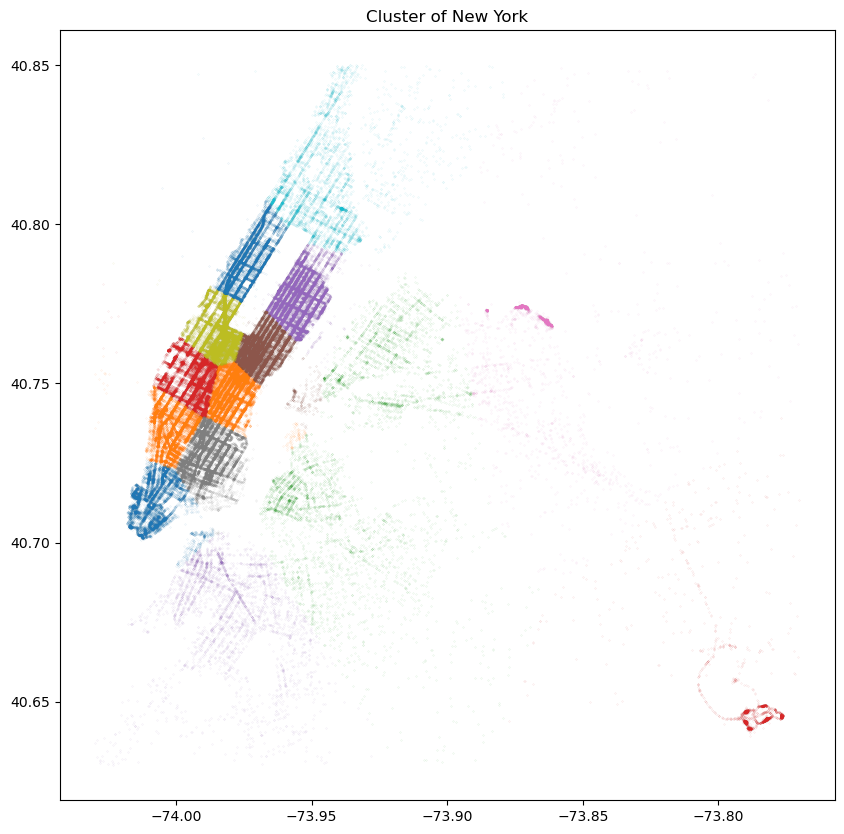

In [28]:
kmeans = KMeans(n_clusters=15, random_state=2, n_init=10).fit(loc_df)
loc_df['label'] = kmeans.labels_

loc_df = loc_df.sample(200000)
plt.figure(figsize = (10,10))

for label in loc_df.label.unique():
    plt.plot(loc_df.longitude[loc_df.label == label], loc_df.latitude[loc_df.label == label], '.', alpha=0.3, markersize = 0.3)
    
    
plt.title('Cluster of New York')
plt.show()

- 보시다시피, 클러스터링으로 인해 뉴욕이 여러 지역으로 나뉘는 방식과 다소 유사한 파티션이 생성됩니다. 
- 센트럴 파크의 어퍼 이스트와 웨스트사이드는 각각 회색과 분홍색으로 표시됩니다. 
- 웨스트 미드타운은 파란색, 첼시와 웨스트 빌리지는 갈색, 다운타운 지역은 파란색, 이스트 빌리지와 소호는 보라색으로 표시됩니다.

- JFK 공항과 라라과디아 공항에는 자체 클러스터가 있으며 퀸즈와 할렘도 마찬가지입니다. 
- 브루클린은 2개의 클러스터로 나뉘며, 브롱크스는 할렘과 분리하기에는 라이드 수가 너무 적습니다.

- 클러스터 중심을 그려 보겠습니다

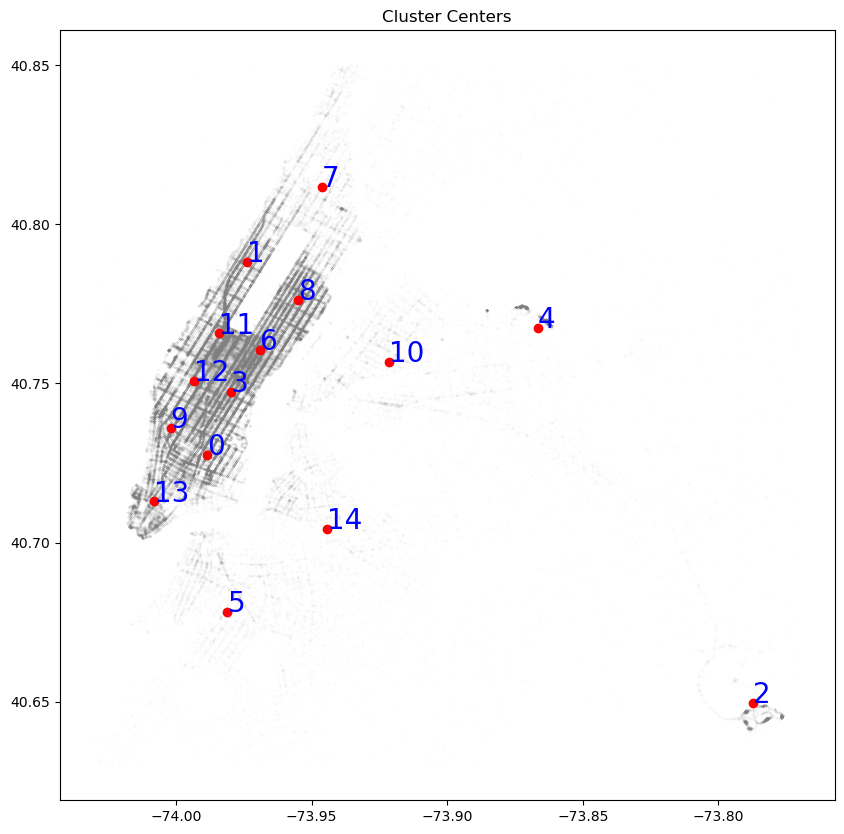

In [33]:
fig, ax = plt.subplots(figsize= (10,10))
for label in loc_df.label.unique():
    ax.plot(loc_df.longitude[loc_df.label == label], loc_df.latitude[loc_df.label == label], '.', alpha=0.4, markersize=0.1, color = 'gray')
    ax.plot(kmeans.cluster_centers_[label,0], kmeans.cluster_centers_[label, 1], 'o', color='r')
    ax.annotate(label, (kmeans.cluster_centers_[label, 0], kmeans.cluster_centers_[label, 1]), color = 'b', fontsize=20)
ax.set_title('Cluster Centers')
plt.show()

In [34]:
df['pickup_cluster'] = kmeans.predict(df[['pickup_longitude', 'pickup_latitude']])
df['dropoff_cluster'] = kmeans.predict(df[['dropoff_longitude', 'dropoff_latitude']])
df['pickup_hour'] = df.pickup_datetime.apply(lambda x : parser.parse(x).hour)



/Users/jeongjiyeong/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- pickup_latitude
- pickup_longitude
Feature names seen at fit time, yet now missing:
- latitude
- longitude

  warnings.warn(message, FutureWarning)
/Users/jeongjiyeong/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- dropoff_latitude
- dropoff_longitude
Feature names seen at fit time, yet now missing:
- latitude
- longitude

  warnings.warn(message, FutureWarning)


In [35]:
df

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_cluster,dropoff_cluster,pickup_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,11,6,17
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,3,9,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11,13,11
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,13,13,19
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1,1,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,3,9,13
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,12,1,7
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,8,13,6
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,3,6,15


In [37]:
clusters = pd.DataFrame()
clusters['x'] = kmeans.cluster_centers_[:,0]
clusters['y'] = kmeans.cluster_centers_[:,1]
clusters['label'] = range(len(clusters))

In [38]:
#클러스터값에 대한 label 확인
clusters

,x,y,label
0,-73.988462,40.727455,0
1,-73.973815,40.788317,1
2,-73.787184,40.649466,2
3,-73.979803,40.747183,3
4,-73.866620,40.767406,4
5,-73.981063,40.678307,5
6,-73.968937,40.760455,6
7,-73.946296,40.811699,7
8,-73.955014,40.776337,8
9,-74.001996,40.736004,9


In [39]:
loc_df = loc_df.sample(5000)

## Taxi rides from one cluster to another

- 다음 애니메이션에서 모든 화살표는 한 클러스터에서 다른 클러스터로의 이동을 나타냅니다. 
- 화살표의 너비는 해당 시간 동안의 상대적인 운행 횟수에 비례합니다.

MovieWriter imagemagick unavailable; using Pillow instead.
/var/folders/cx/dsw_f6590_dbbf9c4vf4fyy40000gn/T/ipykernel_45915/2082614442.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (10,10))



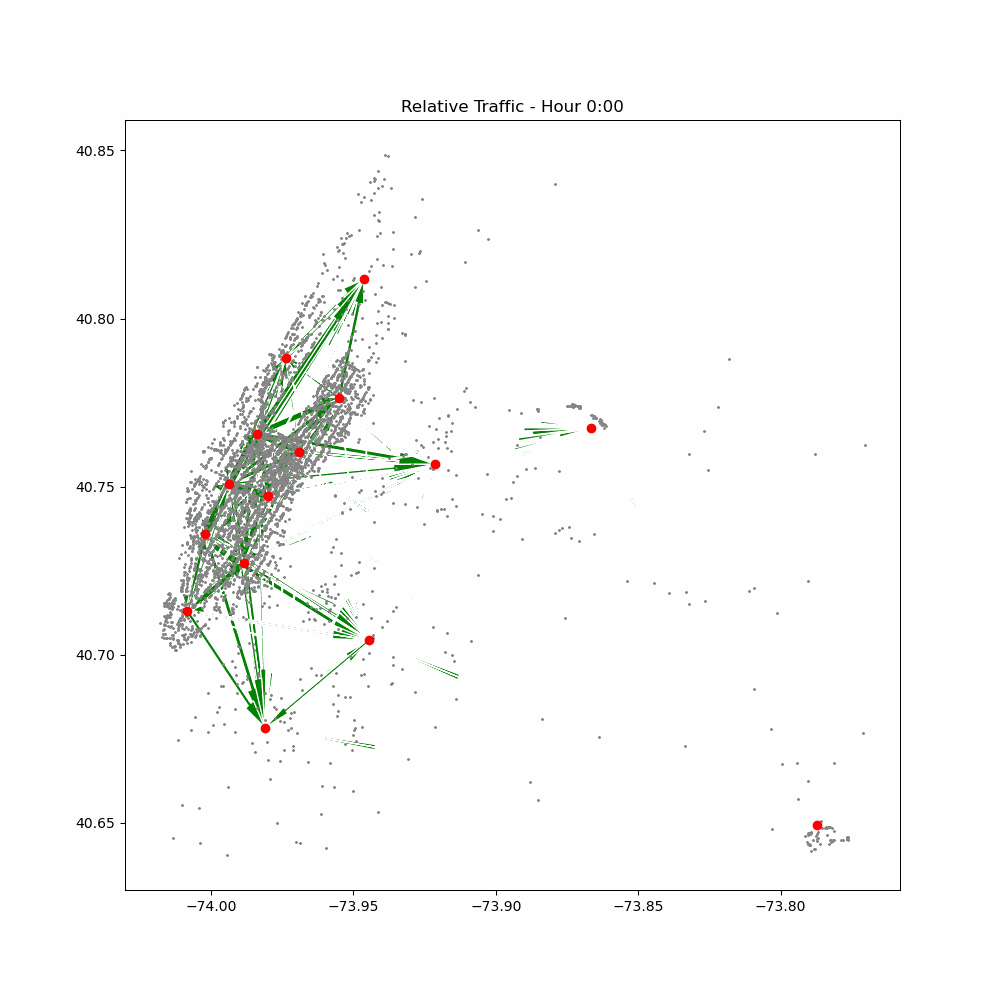

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [44]:
fig, ax = plt.subplots(1, 1, figsize = (10,10))

def animate(hour):
    ax.clear()
    ax.set_title('Relative Traffic - Hour ' + str(int(hour)) + ':00')    
    plt.figure(figsize = (10,10))
    for label in loc_df.label.unique():
        ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 1, markersize = 2, color = 'gray')
        ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r')


    for label in clusters.label:
        for dest_label in clusters.label:
            num_of_rides = len(df[(df.pickup_cluster == label) & (df.dropoff_cluster == dest_label) & (df.pickup_hour == hour)])
            dist_x = clusters.x[clusters.label == label].values[0] - clusters.x[clusters.label == dest_label].values[0]
            dist_y = clusters.y[clusters.label == label].values[0] - clusters.y[clusters.label == dest_label].values[0]
            pct = np.true_divide(num_of_rides,len(df[df.pickup_hour == hour]))
            arr = Arrow(clusters.x[clusters.label == label].values, clusters.y[clusters.label == label].values, -dist_x, -dist_y, edgecolor='white', width = pct)
            ax.add_patch(arr)
            arr.set_facecolor('g')


ani = animation.FuncAnimation(fig,animate,sorted(df.pickup_hour.unique()), interval = 1000)
plt.close()
ani.save('animation.gif', writer='imagemagick', fps=2)
filename = 'animation.gif'
video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

- 맨해튼 내에서 트래픽이 가장 많이 발생함, 시간대는 2~3시?
- 4~5시에는 공항으로 가는 트래픽 많음
- 3~4시에 윌리엄스버그로 가는 트래픽 많음

## Neighborhood Analysis

In [45]:
# 위치별 이름 설정
neighborhood = {-74.0019368351: 'Chelsea',-73.837549761: 'Queens',-73.7854240738: 'JFK',-73.9810421975:'Midtown-North-West',-73.9862336241: 'East Village',
                -73.971273324:'Midtown-North-East',-73.9866739677: 'Brooklyn-parkslope',-73.8690098118: 'LaGuardia',-73.9890572967:'Midtown',-74.0081765545: 'Downtown'
                ,-73.9213024854: 'Queens-Astoria',-73.9470256923: 'Harlem',-73.9555565018: 'Uppe East Side',
               -73.9453487097: 'Brooklyn-Williamsburgt',-73.9745967889:'Upper West Side'}

In [48]:
rides_df = pd.DataFrame(columns = neighborhood.values())
rides_df['name'] = neighborhood.values()
rides_df

,Chelsea,Queens,JFK,Midtown-North-West,East Village,Midtown-North-East,Brooklyn-parkslope,LaGuardia,Midtown,Downtown,Queens-Astoria,Harlem,Uppe East Side,Brooklyn-Williamsburgt,Upper West Side,name
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Chelsea
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Queens
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JFK
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Midtown-North-West
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,East Village
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Midtown-North-East
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Brooklyn-parkslope
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LaGuardia
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Midtown
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Downtown


In [50]:
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(np.array(list(neighborhood.keys())).reshape(-1,1), list(neighborhood.values()))

KNeighborsClassifier(n_neighbors=1)

In [53]:
# 픽업, 드랍오프 경도에 대해 매핑 후 df컬럼에 각각 기록
df['pickup_neighborhood'] = neigh.predict(np.array(df.pickup_longitude).reshape(-1,1))
df['dropoff_neighborhood'] = neigh.predict(np.array(df.dropoff_longitude).reshape(-1,1))
df

/Users/jeongjiyeong/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/jeongjiyeong/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_cluster,dropoff_cluster,pickup_hour,pickup_neighborhood,dropoff_neighborhood
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,11,6,17,Midtown-North-West,Midtown-North-East
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,3,9,0,Midtown-North-West,Chelsea
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11,13,11,Midtown-North-West,Downtown
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,13,13,19,Downtown,Downtown
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1,1,13,Upper West Side,Midtown-North-East
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,3,9,13,Midtown-North-West,Midtown
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,12,1,7,Chelsea,Midtown-North-East
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,8,13,6,Uppe East Side,Chelsea
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,3,6,15,Midtown-North-West,Upper West Side


In [56]:
# 픽업, 드랍오프 위치 별 거리측정
for col in rides_df.columns[:-1]:
    rides_df[col] = rides_df.name.apply(lambda x: len(df[(df.pickup_neighborhood == x) & (df.dropoff_neighborhood == col)]))


In [58]:
rides_df

,Chelsea,Queens,JFK,Midtown-North-West,East Village,Midtown-North-East,Brooklyn-parkslope,LaGuardia,Midtown,Downtown,Queens-Astoria,Harlem,Uppe East Side,Brooklyn-Williamsburgt,Upper West Side,name
0,28526,228,950,18989,10622,7657,6141,1497,35963,22084,2119,2209,7998,2317,8742,Chelsea
1,27,375,93,55,37,20,5,120,33,24,43,15,43,15,41,Queens
2,1887,1221,2779,3578,2116,2351,743,1463,3207,1576,1749,993,2847,1244,2208,JFK
3,17496,416,2183,30833,13214,27005,6747,4206,35307,10196,2940,4654,22343,3898,23537,Midtown-North-West
4,10616,186,1168,13532,5619,8030,2622,2073,16225,5980,1625,1793,7099,1704,9138,East Village
5,7069,331,1346,24433,7833,25085,3355,2757,15474,4846,2669,6776,37879,5258,19356,Midtown-North-East
6,6225,116,439,8320,2907,4031,1612,802,8282,3397,1070,1026,3830,1108,4751,Brooklyn-parkslope
7,2055,950,793,5189,2958,3550,949,2620,3938,2256,2497,1230,3509,1591,3582,LaGuardia
8,37829,474,1833,41685,17402,18089,8724,3174,43352,22124,4277,4532,17223,4826,22242,Midtown
9,20509,187,869,10457,5776,5202,3295,1626,19725,21964,1095,1258,4792,1231,6167,Downtown


In [67]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

# np.array(rides_df.as_matrix()) => rides_df.values 코드로 변경
trace = go.Heatmap(z = rides_df.values,
                  x = rides_df.columns[:-1],
                  y = rides_df.columns)

layout = dict(
    title = ' <b>Neighborhoods Interaction</b>',
    titlefont = dict(
    size = 30,
    color = ('rgb(100,100,100)')),
    margin = dict(t=100,r=100,b=100,l=150),
        yaxis = dict(
            title = ' <b> From </b>'),
        xaxis = dict(
            title = '<b> To </b>'))
data=[trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')


In [69]:
rides_df.index = rides_df.name
rides_df = rides_df.drop('name', axis=1)

- 시각화 결과 midtownrhk uppe east side의 교통량이 가장 많은 것을 알 수 있음
- 대칭적이므로 특별히 많이 승차하는 구역이나 많이 하차하는 구역은 없음을 알 수 있음

Text(0.5, 1.0, 'Inbound and Outbound rides for each cluster')

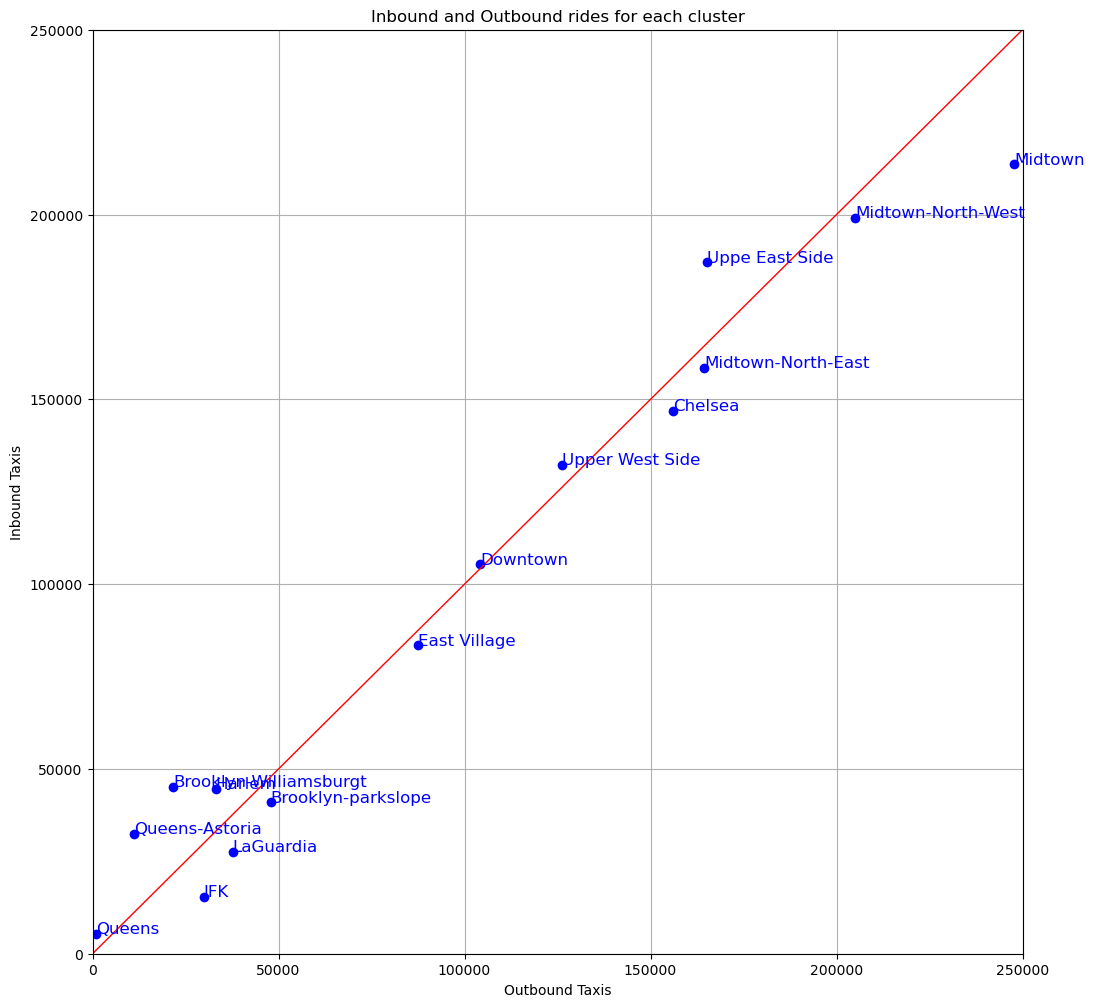

In [70]:
fig,ax = plt.subplots(figsize = (12,12))

for i in range(len(rides_df)):  
    ax.plot(rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i],'o', color = 'b')
    ax.annotate(rides_df.index.tolist()[i], (rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i]), color = 'b', fontsize = 12)

ax.plot([0,250000],[0,250000], color = 'r', linewidth = 1)
ax.grid('off')
ax.set_xlim([0,250000])
ax.set_ylim([0,250000])
ax.set_xlabel('Outbound Taxis')
ax.set_ylabel('Inbound Taxis')
ax.set_title('Inbound and Outbound rides for each cluster')

- 대부분 인바운드 아웃바운드가 균형을 이루나, 공항이 있는 곳은 인바운드가 더 많음(대각선 상단)
- 주거지역은 인바운드가 많음(퀸즈, 브루클린, 할렘)
- 상업이며 관광지역 or 상업 주거지역은 아웃바운드가 많음(어퍼 이스트, 웨스트)
- 맨하탄은 다른 교통수단을 통해 방문하고 택시를 통해 나가는 경향

## Winter vs Summer

In [71]:
# datetime 컬럼에서 월만 분리하여 month 컬럼 생성
df['pickup_month'] = df.pickup_datetime.apply(lambda x: parser.parse(x).month )

/var/folders/cx/dsw_f6590_dbbf9c4vf4fyy40000gn/T/ipykernel_45915/4215828877.py:11: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

/var/folders/cx/dsw_f6590_dbbf9c4vf4fyy40000gn/T/ipykernel_45915/4215828877.py:12: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



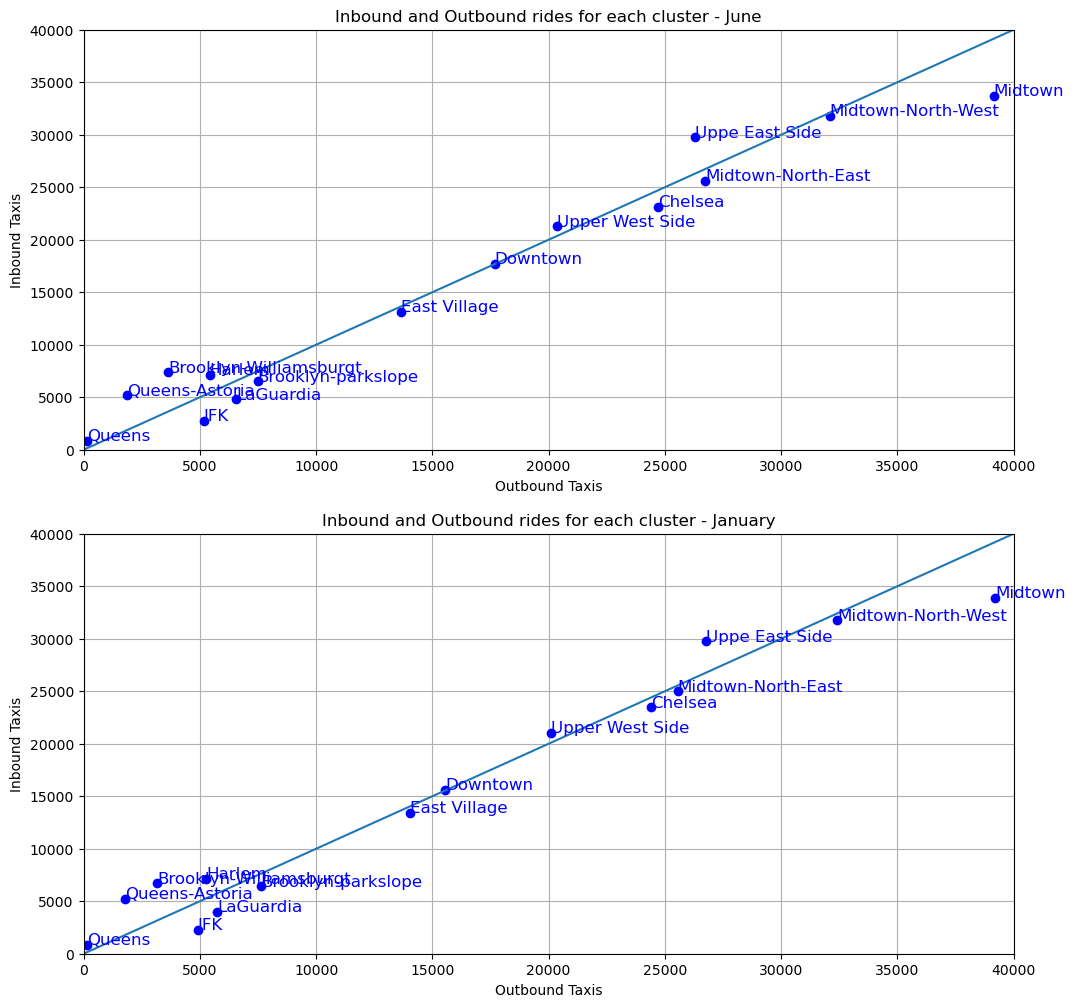

In [72]:
fig,ax = plt.subplots(2,figsize = (12,12))

rides_df = pd.DataFrame(columns = neighborhood.values())
rides_df['name'] = neighborhood.values()
rides_df.index = rides_df.name


for col in rides_df.columns[:-1]:
    rides_df[col] = rides_df.name.apply(lambda x: len(df[(df.pickup_neighborhood == x) & (df.dropoff_neighborhood == col) & (df.pickup_month == 6)]))
for i in range(len(rides_df)):  
    ax[0].plot(rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i],'o', color = 'b')
    ax[0].annotate(rides_df.index.tolist()[i], (rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i]), color = 'b', fontsize = 12)

ax[0].grid('off')
ax[0].set_xlabel('Outbound Taxis')
ax[0].set_ylabel('Inbound Taxis')
ax[0].set_title('Inbound and Outbound rides for each cluster - June')
ax[0].set_xlim([0,40000])
ax[0].set_ylim([0,40000])
ax[0].plot([0,40000],[0,40000])

for col in rides_df.columns[:-1]:
    rides_df[col] = rides_df.name.apply(lambda x: len(df[(df.pickup_neighborhood == x) & (df.dropoff_neighborhood == col) & (df.pickup_month == 1)]))
rides_df = rides_df.drop('name', axis = 1)
for i in range(len(rides_df)):  
    ax[1].plot(rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i],'o', color = 'b')
    ax[1].annotate(rides_df.index.tolist()[i], (rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i]), color = 'b', fontsize = 12)

ax[1].grid('off')
ax[1].set_xlabel('Outbound Taxis')
ax[1].set_ylabel('Inbound Taxis')
ax[1].set_title('Inbound and Outbound rides for each cluster - January')
ax[1].set_xlim([0,40000])
ax[1].set_ylim([0,40000])
ax[1].plot([0,40000],[0,40000])